Hyperparameter Tuning is after Cross Validation part. The best parameters from
the tuning process were used in CV.

# Feature Extraction

In [21]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

mpl.rcParams['figure.dpi']= 150

In [1]:

class readData:
    def __init__(self):
        self.State = []
        self.Lat = []
        self.Long = []
        self.BHT = []
        self.Depth = []
        self.Elev = []
        self.COSUNA_ID = []
        self.Basemend_depth = []
        self.Surface_temp = []
        self.Gradient = []
        self.Heat_flow = []
        self.Basement_rad_heat = []
        self.K_avg = []
        self.trainIndx = []
        self.testIndx = []
        self.KL= []
        self.Layers = []
        self.Conducs = []
        with open('AASG_Thermed_AllTempsThicksConds.csv','r') as csv_file:
            csv_reader = csv.reader(csv_file)
            count = 0

            helper1 = []
            helper2 = []
            #kMultL=np.zeros(shape=(2,50))

            count = 0
            #reading csv file line by line
            for line in csv_reader:
                #ignore the first line
                if count>0:
                    # get rid of outliers
                    #if K_avg[i]<0.5 and BHT[i]>120 and Heat_flow[i]>90 and Heat_flow[i]<20 and Depth[i]>3500:
                    if float(line[51])<0.5 or float(line[36])>180 or float(line[39])>140 or float(line[39])<20 or float(line[18])>4000:
                        pass
                    else:
                        self.State.append(line[5])
                        self.Lat.append(line[6])
                        self.Long.append(line[7])
                        self.BHT.append(line[36])
                        self.Depth.append(line[18])
                        self.Elev.append(line[20])
                        self.COSUNA_ID.append(line[27])
                        self.Basemend_depth.append(line[29])
                        self.Surface_temp.append(line[30])
                        self.Gradient.append(line[38])
                        self.Heat_flow.append(line[39])
                        self.Basement_rad_heat.append(line[40])
                        self.K_avg.append(line[51])
                        helper1 = []
                        helper2 = []
                        for jj in range(0,49):
                            Par = line[52+jj]
                            if(Par!=''):
                                helper1.append(Par)
                                helper2.append(line[101+jj])
                            else:
                                helper1.append(0)
                                helper2.append(0)
                        self.Layers.append(helper1)
                        self.Conducs.append(helper2)


                count = count + 1
            self.State = np.array(self.State[1:-1])
            self.Lat = np.array(self.Lat[1:-1]).astype(np.float)
            self.Long = np.array(self.Long[1:-1]).astype(np.float)
            self.BHT = np.array(self.BHT[1:-1]).astype(np.float) +273.15
            self.Depth = np.array(self.Depth[1:-1]).astype(np.float)
            self.Elev = np.array(self.Elev[1:-1]).astype(np.float)
            self.COSUNA_ID = np.array(self.COSUNA_ID[1:-1]).astype(np.float)
            self.Basemend_depth = np.array(self.Basemend_depth[1:-1]).astype(np.float)
            self.Surface_temp = np.array(self.Surface_temp[1:-1]).astype(np.float) +273.15
            self.Gradient = np.array(self.Gradient[1:-1]).astype(np.float)
            self.Heat_flow = np.array(self.Heat_flow[1:-1]).astype(np.float)
            self.Basement_rad_heat = np.array(self.Basement_rad_heat[1:-1]).astype(np.float)
            self.K_avg = np.array(self.K_avg[1:-1]).astype(np.float)
            self.Layers = np.array(self.Layers[1:-1]).astype(np.float)
            self.Conducs = np.array(self.Conducs[1:-1]).astype(np.float)
            self.Delta_T = self.BHT - self.Surface_temp
            self.KL = self.Layers*self.Conducs
        
    def testTrainData(self):
        self.trainIndx = []
        self.testIndx = np.array(random.sample(range(1, self.BHT.size), round(0.1*self.BHT.size)))

        for i in range(0,self.BHT.size):
            if i in self.testIndx[:]:
                pass
            else:
                self.trainIndx.append(i)
        self.trainIndx = np.array(self.trainIndx)
        return self.trainIndx;

    def trainDataset(self,Param):
        global trainIndx
        return Param[self.trainIndx]
    
    def testDataset(self,Param):
        global testIndx
        return Param[self.testIndx]


data = readData();

# Let's now generate the data we need.
# Thick_Con is thickness times conductivity for each layer
thick_con = np.multiply(data.Layers, data.Conducs)

# Our label
df = pd.DataFrame({'lon':data.Long, 'lat':data.Lat, 'k_avg': data.K_avg, 't_surf':data.Surface_temp, 'z':data.Depth})

# split into input (X) and output (Y) variables
dataset = df.values
# Combine df values and the thick_con values
X = np.concatenate((df.values, thick_con), axis=1)
Y = data.BHT

In [8]:
df = pd.read_csv('AASG_Thermed_AllTempsThicksConds.csv',low_memory=False)
# Drop 3 sigma outliers for HeatFlow
def outlierDrop(df,df_toCheck,std_cut_off):
    init_len = df.shape[0]
    for i in df_toCheck:
        mean = df[i].mean()
        std = df[i].std()
        cut_off = std * std_cut_off
        lower, upper =mean - cut_off, mean + cut_off
        df = df[(df[i] < upper) & (df[i] > lower)]
    print("numbere of outliers removed: ", init_len - df.shape[0])
    return df
df = outlierDrop(df,['HeatFlow'],3)
df = df[df['HeatFlow']>0]
df.reset_index(inplace=True, drop=True)

# Form X and Y
X = np.transpose(np.array([df.LatDegree,
                                df.LongDegree,
                                df.MeasureDepth_m,
                                df.SurfTemp]))
Y = df.CorrBHT
# Add Geological Layer information to X
layers = df.iloc[:,52:101].values
conds = df.iloc[:,101:150].values
mult = np.multiply(layers,conds)
np.nan_to_num(mult, 0)
X = np.concatenate((X, mult),axis=1)

numbere of outliers removed:  67


# Tuning Ridge

In [11]:
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

In [12]:
def RidgeLoop(a):
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, Y, test_size=0.10, random_state=0)
    rid = Ridge(alpha=a)
    rid.fit(X_train, y_train)
    y_pred = rid.predict(X_test)
    return m.mean_absolute_error(y_test, y_pred)

In [13]:
res = []
param = []
for i in np.logspace(-1, 1, 30):
    param.append(i)
    res.append(RidgeLoop(i))

Text(0.5, 1.0, 'Error Rate for Regularization Weight')

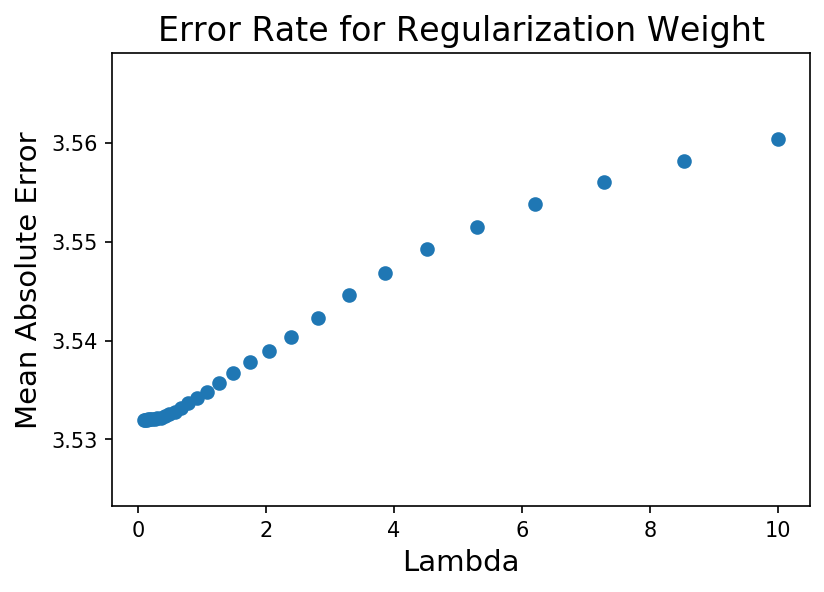

In [14]:
plt.scatter(param, res)
plt.xlabel('Lambda', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.title('Error Rate for Regularization Weight', fontsize=16)

# Tuning Random Forest

In [22]:
def RfLoop(depth):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=0)
    model = RandomForestRegressor(max_depth=depth, n_estimators=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return m.mean_absolute_error(y_test, y_pred)

In [23]:
res = []
param = []
for i in np.linspace(2,15,14):
    param.append(i)
    res.append(RfLoop(i))

Text(0.5, 1.0, 'Error Rate for Depth')

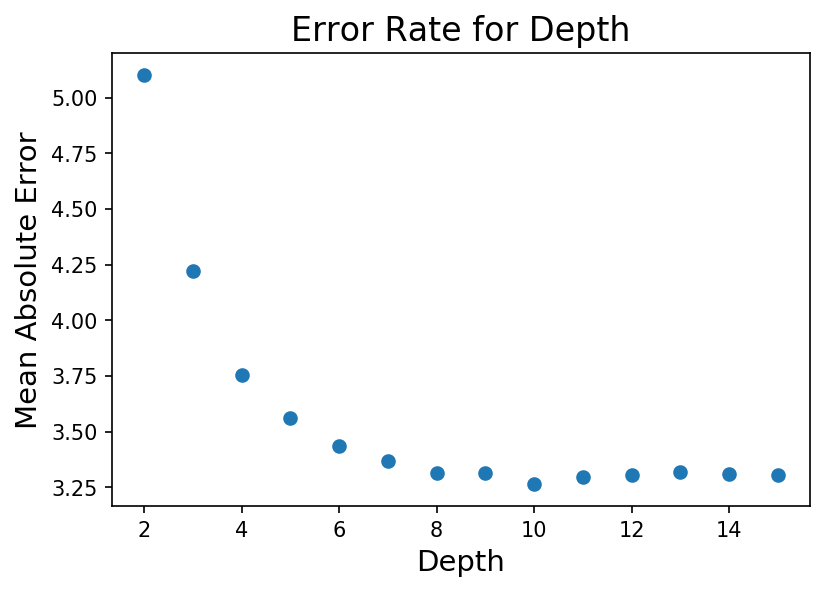

In [24]:
plt.scatter(param, res)
plt.xlabel('Depth', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.title('Error Rate for Depth', fontsize=16)

# Tuning XGBoost

In [7]:
# Running many of Random search gives insight to best parameters
# You can poke a few times to get an estimate of good hyperparmeters to do grid search
# learning rate and estimators don't need to be tuned. Smaller learning rate with more estimators is 
# almost always better.
# We found this method not working well.

In [ ]:
# Second part of tuning was to exhaustively search around the best parameters
# depth was always 10 or 12 for randomized search, so we set that a constant as well.

In [17]:
# 10 bootstrapped cross-validation
def xgb_10cv(a,l,g):

    mae = []
    mse = []
    std = []
    for q in range(0,10):
        t = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=int(100*np.random.random()))
        gbm = xgb.XGBRegressor(learning_rate=0.01,
                               objective='reg:squarederror', 
                               n_estimators=2000, 
                               reg_alpha = a,
                               reg_lambda = l,
                               max_depth=10,
                               gamma=g)
        gbm.fit(X_train, y_train)
        y_pred = gbm.predict(X_test)
        # very rarely nan can be produced (it's a bug), so we need to customize
        mae.append(np.nanmean(abs(y_test-y_pred)))
        mse.append(np.nanmean(abs(y_test-y_pred)**2))
        std.append(np.nanstd(abs(y_test-y_pred)))
        elapsed = time.time() - t
        print(elapsed, "seconds for model#",q)
    return np.mean(mae), np.mean(mse), np.mean(std)

In [ ]:
result = []
# This takes about 4 hours on 10 GTX 1060. That means 40 hours on a single one.
for i in [0.1, 1, 10, 100]:
    for j in [0, 0.1, 1, 10, 100]:
        for k in [0, 0.1, 1, 10, 100]:
            mae, mse, std = xgb_10cv(i,j,k)
            print(mae, mse, std)
            result.append([i,j,k,mae,mse,std])

In [2]:
# Saved from bootsrapped run. (Every row is average over 10 bootstrapped runs)
# Format is [alpha, lambda, gamma, mae, rmse, std]
result = np.array([[0, 0, 0, 3.1742260711685555, 23.608364859049196, 3.676583120721162],
                   [0, 0, 0.1, 3.1700132140038217, 23.232415305346855, 3.6292010091106506],
                   [0, 0, 1, 3.127239153466295, 23.27012808745679, 3.66832726598647],
                   [0, 0, 10, 3.187984213368767, 24.149312686816895, 3.7335643072941735],
                   [0, 0, 100, 3.173548892381684, 23.323721789329507, 3.63478005051502],
                   [0, 0.1, 0, 3.0906929083294132, 22.416002652370388, 3.578804543736717],
                   [0, 0.1, 0.1, 3.1381551064795365, 23.271963231570098, 3.657764489373494],
                   [0, 0.1, 1, 3.101144279638142, 22.5043939265272, 3.5873901688014045],
                   [0, 0.1, 10, 3.108326715467478, 22.315234904293696, 3.554618051259059],
                   [0, 0.1, 100, 3.151931867413084, 22.262350660144044, 3.5046353685282967],
                   [0, 1, 0, 3.127884579205678, 23.174383473058207, 3.656662048492488],
                   [0, 1, 0.1, 3.111401936808791, 22.219996591465595, 3.5376297029476573],
                   [0, 1, 1, 3.110490396512814, 23.042196888744943, 3.6520293706100206],
                   [0, 1, 10, 3.126224162968809, 23.127250648769348, 3.648249793118911],
                   [0, 1, 100, 3.10618291778414, 21.77238626530351, 3.4795060176834602],
                   [0, 10, 0, 3.146539196680942, 23.3639999666681, 3.6637525023344333],
                   [0, 10, 0.1, 3.0783165645919457, 21.807262967333674, 3.5061382146540083],
                   [0, 10, 1, 3.1274127983552686, 22.951088698487716, 3.6240911479806677],
                   [0, 10, 10, 3.0814496421399737, 21.90525499712495, 3.513888833052608],
                   [0, 10, 100, 3.1584624645236934, 22.7527337315171, 3.564430930977477],
                   [0, 100, 0, 3.08628367664454, 21.67241198128751, 3.481869419058154],
                   [0, 100, 0.1, 3.1067598976368735, 22.142904390345883, 3.524960569816497],
                   [0, 100, 1, 3.1177045071179172, 22.14995970252888, 3.5190923638926592],
                   [0, 100, 10, 3.1265109216778564, 22.771014058272506, 3.6012105290840593],
                   [0, 100, 100, 3.172922136191908, 22.51969276392375, 3.5241000701902685],
                   [0.1, 0, 0, 3.1624081734453027, 23.468522062633234, 3.6638465183118023],
                   [0.1, 0, 0.1, 3.1919003614075505, 24.01986689702407, 3.714740613136563],
                   [0.1, 0, 1, 3.172118297812704, 23.79617383790005, 3.6976926967768393],
                   [0.1, 0, 10, 3.1833872116840913, 24.39420885653443, 3.7713637025301217],
                   [0.1, 0, 100, 3.1754837602673076, 23.407657659344974, 3.6470312212229246],
                   [0.1, 0.1, 0, 3.1494629370792016, 23.525128672183765, 3.6834316912706413],
                   [0.1, 0.1, 0.1, 3.159065155179927, 23.220066578213526, 3.6337063043918425],
                   [0.1, 0.1, 1, 3.1289948734686384, 23.15199779878958, 3.649358484323139],
                   [0.1, 0.1, 10, 3.089575740531779, 21.813939661559576, 3.4957932854879936],
                   [0.1, 0.1, 100, 3.122023911260547, 22.12712065818265, 3.510790442139785],
                   [0.1, 1, 0, 3.1510148521491126, 23.454097558312508, 3.672542650387375],
                   [0.1, 1, 0.1, 3.1555869985356386, 23.202579963065944, 3.6337828203250426],
                   [0.1, 1, 1, 3.11973777567646, 22.68547688463517, 3.5964977762219603],
                   [0.1, 1, 10, 3.0972467316366723, 22.59474581940803, 3.6032065301547314],
                   [0.1, 1, 100, 3.1113826751257103, 21.993652538794915, 3.5026368690696708],
                   [0.1, 10, 0, 3.1377580237430984, 23.11352505993572, 3.6346876533374504],
                   [0.1, 10, 0.1, 3.1193736334873217, 22.96297545365438, 3.628470220933616],
                   [0.1, 10, 1, 3.115845944976054, 22.28788669661734, 3.54485569219354],
                   [0.1, 10, 10, 3.0990691943455784, 21.789053881704184, 3.4853235693317295],
                   [0.1, 10, 100, 3.1699698438126633, 23.274042098470602, 3.6324076682576396],
                   [0.1, 100, 0, 3.0674210402101787, 21.41476001092455, 3.461022425125732],
                   [0.1, 100, 0.1, 3.1139714054811862, 21.99054939474359, 3.502248075559327],
                   [0.1, 100, 1, 3.1007199655817153, 21.202019417061837, 3.4008174489774534],
                   [0.1, 100, 10, 3.1489221963232863, 22.68691256497592, 3.5698826190506296],
                   [0.1, 100, 100, 3.1594879783637912, 22.795387271664794, 3.5724740166547613],
                   [1, 0, 0, 3.1453280807380053, 22.96663878764182, 3.611807715643161],
                   [1, 0, 0.1, 3.0999323817140363, 22.378377730185406, 3.5685497124853613],
                   [1, 0, 1, 3.1620187581926498, 23.143610901322724, 3.6182860700022106],
                   [1, 0, 10, 3.160195360503225, 23.136892468376324, 3.624091996366083],
                   [1, 0, 100, 3.1280874990798067, 21.81856658616478, 3.4644787630879477],
                   [1, 0.1, 0, 3.1240035823358836, 23.529409971725592, 3.698521063891312],
                   [1, 0.1, 0.1, 3.065470896292534, 21.613600752564874, 3.4922457943079492],
                   [1, 0.1, 1, 3.0930584423972736, 22.25707684357982, 3.5539894928628684],
                   [1, 0.1, 10, 3.1443586507723813, 23.359067747107336, 3.665339274484942],
                   [1, 0.1, 100, 3.1503359803993405, 23.107386925458687, 3.6257508899085864],
                   [1, 1, 0, 3.1298853207858395, 22.76617901565126, 3.5916706842512456],
                   [1, 1, 0.1, 3.104127327831453, 22.29599611606099, 3.556239311216747],
                   [1, 1, 1, 3.1428388703205985, 23.57272879017383, 3.6967767435552226],
                   [1, 1, 10, 3.0780546286941632, 22.100888932929546, 3.548708914801587],
                   [1, 1, 100, 3.1243807091670592, 22.486703581453398, 3.563717099846265],
                   [1, 10, 0, 3.0785274996216185, 21.758979852463543, 3.495508242470263],
                   [1, 10, 0.1, 3.1115810143187397, 21.866173298594283, 3.4879363135751866],
                   [1, 10, 1, 3.104759542452031, 22.46750423443126, 3.5776028269840277],
                   [1, 10, 10, 3.090624360426275, 22.39282438097841, 3.57544780868416],
                   [1, 10, 100, 3.1390989199127177, 22.393600996126857, 3.5347030779509447],
                   [1, 100, 0, 3.1365932441854527, 23.241617522170344, 3.654763768524198],
                   [1, 100, 0.1, 3.073560927124627, 21.32640551147322, 3.443363731772738],
                   [1, 100, 1, 3.1006676709249485, 21.9488947982833, 3.5076555174061377],
                   [1, 100, 10, 3.1327405489500757, 22.34283364308609, 3.537946425667042],
                   [1, 100, 100, 3.1540239398801915, 21.945120180682373, 3.4604984596916077],
                   [10, 0, 0, 3.0658230226863545, 22.190557213609335, 3.564366855062559],
                   [10, 0, 0.1, 3.1077863850637386, 22.946017750635498, 3.6387217329271175],
                   [10, 0, 1, 3.1504010070922925, 23.749383153042942, 3.7098391342169266],
                   [10, 0, 10, 3.144521563758535, 23.37398420395169, 3.6658528963416486],
                   [10, 0, 100, 3.1303034691114107, 22.206313189609446, 3.520125330162906],
                   [10, 0.1, 0, 3.1100797089617203, 22.80287455841825, 3.620673105258516],
                   [10, 0.1, 0.1, 3.095453914661163, 22.104341680101456, 3.536722387430874],
                   [10, 0.1, 1, 3.073713193450958, 22.052387527767955, 3.5442841733798245],
                   [10, 0.1, 10, 3.121200257914206, 22.610243714178768, 3.5834186513170607],
                   [10, 0.1, 100, 3.163948521454973, 23.150873300307637, 3.6210947064682744],
                   [10, 1, 0, 3.1424187366602334, 23.28678371539284, 3.655836163415677],
                   [10, 1, 0.1, 3.085689703471569, 21.955754039630087, 3.522801084737445],
                   [10, 1, 1, 3.1203651709297686, 23.435155622448242, 3.695571113025019],
                   [10, 1, 10, 3.0526496192201575, 21.388420464838898, 3.4682481595915973],
                   [10, 1, 100, 3.092729033369421, 21.623054746102206, 3.465671822851822], 
                   [10, 10, 0, 3.056288550539761, 21.367241377003374, 3.4653421286528703], 
                   [10, 10, 0.1, 3.068227460674802, 21.788396939414028, 3.5102770091528357],
                   [10, 10, 1, 3.076466518451054, 22.109444194766446, 3.5529962319884354], 
                   [10, 10, 10, 3.087737778448047, 22.639091226029432, 3.6147150324751633],
                   [10, 10, 100, 3.1166105591904856, 21.436716151916432, 3.4196454367896], 
                   [10, 100, 0, 3.12496563009731, 22.547321953492606, 3.5670272443677136], 
                   [10, 100, 0.1, 3.1488842761387135, 22.24203411585102, 3.5060488174414095],
                   [10, 100, 1, 3.119991794717983, 22.779780015004967, 3.6047812441495566], 
                   [10, 100, 10, 3.104723584249484, 22.057948545298764, 3.518349415229701], 
                   [10, 100, 100, 3.176466658054665, 22.85660443229774, 3.5677953581144854],
                   [100, 0, 0, 3.1081477983480386, 22.096117235799852, 3.5232905122168345],
                   [100, 0, 0.1, 3.061894616566665, 21.40586388103201, 3.463123595181081],
                   [100, 0, 1, 3.1266175494330546, 22.44420690308137, 3.550868285669915],
                   [100, 0, 10, 3.106621177801376, 22.894424424041482, 3.6285779361347332],
                   [100, 0, 100, 3.135660269282531, 21.975055362453976, 3.4819508386651927],
                   [100, 0.1, 0, 3.1190558782579396, 22.41687876142758, 3.5591768698344834],
                   [100, 0.1, 0.1, 3.084974570331781, 21.574839550306628, 3.467133791246274],
                   [100, 0.1, 1, 3.1254450398602356, 22.15632234658699, 3.5144433003794058],
                   [100, 0.1, 10, 3.0663155648324714, 21.234787247967585, 3.4378337285591853],
                   [100, 0.1, 100, 3.1867990986559507, 23.07418408214013, 3.586334023696459], 
                   [100, 1, 0, 3.108188376363621, 22.39992229265933, 3.5665427264569587],
                   [100, 1, 0.1, 3.0485273891196676, 21.00235211668695, 3.416312276937364],
                   [100, 1, 1, 3.088298006289333, 21.915962630925122, 3.5125043625347745],
                   [100, 1, 10, 3.055915833483562, 21.549716413078617, 3.4911235026991614],
                   [100, 1, 100, 3.204518582162359, 23.276252756648834, 3.600484135005023], 
                   [100, 10, 0, 3.113775388395681, 22.24092056894771, 3.537319828650111], 
                   [100, 10, 0.1, 3.097733485923233, 22.0263787974413, 3.517243516004519], 
                   [100, 10, 1, 3.1385347584670766, 22.572885594926422, 3.5634210357690437],
                   [100, 10, 10, 3.102949907549513, 22.704801728152372, 3.612802713072567],
                   [100, 10, 100, 3.1483965774039064, 22.487949788178575, 3.5375089671733884],
                   [100, 100, 0, 3.113795307969059, 22.0046327810518, 3.504346943623033], 
                   [100, 100, 0.1, 3.117024680677077, 22.406556377670636, 3.5562041869733476],
                   [100, 100, 1, 3.083652812931404, 21.612853248929785, 3.469850399390937],
                   [100, 100, 10, 3.1405501467374335, 22.947041965776506, 3.6092075873485023],
                   [100, 100, 100, 3.2080108379879926, 23.683375950189905, 3.656175045935459]])

In [3]:
# find minimum error
print(result[result[:,4].argmin()]) # minimum rmse - stable results
print(result[result[:,3].argmin()]) # minimum mae - if large error is just as bad as small error, this is better

[100.           1.           0.1          3.04852739  21.00235212
   3.41631228]
[100.           1.           0.1          3.04852739  21.00235212
   3.41631228]


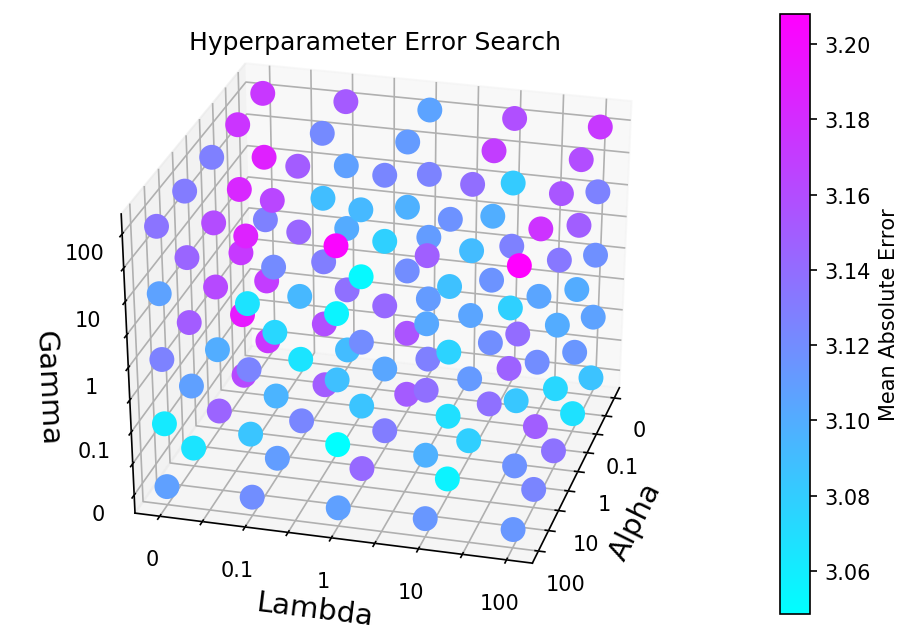

In [8]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(30, 15)

import pandas as pd
df = pd.DataFrame({'x':result[:,0],'y':result[:,1],'z':result[:,2]})
x_ = df.x.astype('category').cat.codes
y_ = df.y.astype('category').cat.codes
z_ = df.z.astype('category').cat.codes

p = ax.scatter3D(x_,y_,z_,c=result[:,3], cmap='cool', s=120, alpha=1);
ax.set_xlabel('Alpha', fontsize=14, rotation = 0)
ax.set_ylabel('Lambda', fontsize=14, rotation = 0)
ax.set_zlabel('Gamma', fontsize=14, rotation = 0)
plt.title('Hyperparameter Error Search')

# from https://stackoverflow.com/questions/11244514/modify-tick-label-text
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['',0,'',0.1,'',1,'',10,'',100]
ax.set_xticklabels(labels)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels = ['',0,'',0.1,'',1,'',10,'',100]
ax.set_yticklabels(labels)

labels = [item.get_text() for item in ax.get_zticklabels()]
labels = ['',0,'',0.1,'',1,'',10,'',100]
ax.set_zticklabels(labels)


cbar=plt.colorbar(p)
cbar.set_label("Mean Absolute Error")

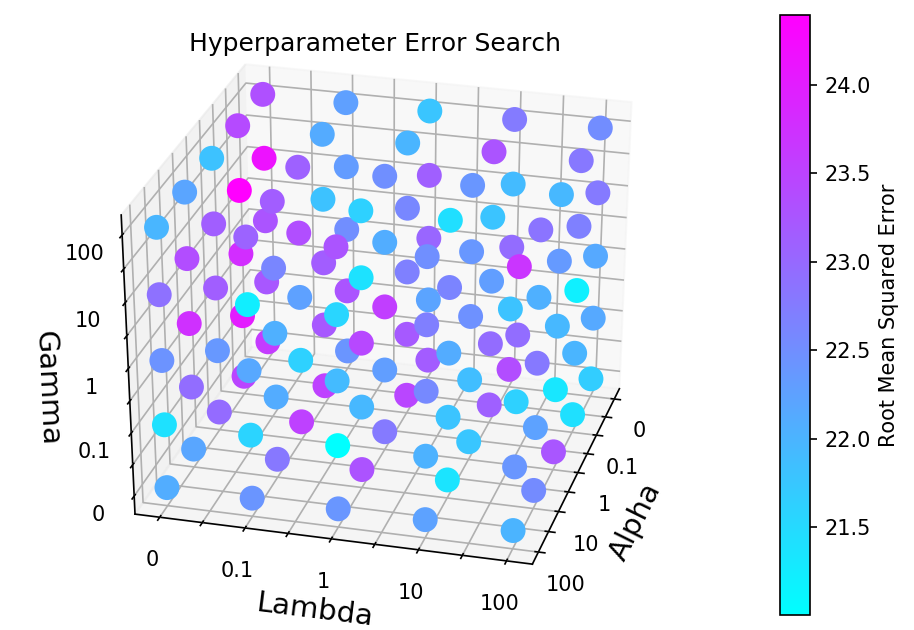

In [10]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(30, 15)

import pandas as pd
df = pd.DataFrame({'x':result[:,0],'y':result[:,1],'z':result[:,2]})
x_ = df.x.astype('category').cat.codes
y_ = df.y.astype('category').cat.codes
z_ = df.z.astype('category').cat.codes

p = ax.scatter3D(x_,y_,z_,c=result[:,4], cmap='cool', s=120, alpha=1);
ax.set_xlabel('Alpha', fontsize=14, rotation = 0)
ax.set_ylabel('Lambda', fontsize=14, rotation = 0)
ax.set_zlabel('Gamma', fontsize=14, rotation = 0)
plt.title('Hyperparameter Error Search')

# from https://stackoverflow.com/questions/11244514/modify-tick-label-text
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['',0,'',0.1,'',1,'',10,'',100]
ax.set_xticklabels(labels)

labels = [item.get_text() for item in ax.get_yticklabels()]
labels = ['',0,'',0.1,'',1,'',10,'',100]
ax.set_yticklabels(labels)

labels = [item.get_text() for item in ax.get_zticklabels()]
labels = ['',0,'',0.1,'',1,'',10,'',100]
ax.set_zticklabels(labels)


cbar=plt.colorbar(p)
cbar.set_label("Root Mean Squared Error")

# DNN Tuning is Abbreviated.

# CV for Ridge

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

In [12]:
def RidgeRandom():
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, Y, test_size=0.10, random_state=int(100*np.random.random()))
    rid = Ridge(alpha=1)
    rid.fit(X_train, y_train)
    y_pred = rid.predict(X_test)
    std = (np.nanstd(abs(y_test-y_pred)))
    return m.mean_absolute_error(y_test, y_pred), m.mean_squared_error(y_test, y_pred), std

In [14]:
mae_ridge = []
mse_ridge = []
std_ridge = []

for i in range(0, 10):
    mae, mse, std = RidgeRandom()
    mae_ridge.append(mae)
    mse_ridge.append(mse)
    std_ridge.append(std)
print(np.mean(mae_ridge), np.sqrt(np.mean(mse_ridge)), np.mean(std_ridge)) 

3.4770285525011992 5.120537057697448 3.755707428413011


# CV for RF

In [15]:
def RfRandom():
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=int(100*np.random.random()))
    model = RandomForestRegressor(max_depth=10, n_estimators=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    std = (np.nanstd(abs(y_test-y_pred)))
    return m.mean_absolute_error(y_test, y_pred), m.mean_squared_error(y_test, y_pred), std

In [19]:
mae_rf = []
mse_rf = []
std_rf = []

for i in range(0, 10):
    mae, mse, std = RfRandom()
    mae_rf.append(mae)
    mse_rf.append(mse)
    std_rf.append(std)
print(np.mean(mae_rf), np.sqrt(np.mean(mse_rf)), np.mean(std_rf)) 

3.1358003996370845 4.744797928436539 3.5567234610615492


# CV for XGBoost

In [20]:
import xgboost as xgb
mae_xgb = []
mse_xgb = []
std_xgb = []
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=(int(100*np.random.random())))
    gbm = xgb.XGBRegressor(learning_rate=0.01,  
                           objective='reg:squarederror', 
                           n_estimators=2000, 
                           reg_alpha=100,
                           reg_lambda=1,
                           max_depth=10, 
                           gamma=0.1)
    gbm.fit(X_train, y_train)
    y_pred = gbm.predict(X_test)
    mae_xgb.append(m.mean_absolute_error(y_test, y_pred))
    mse_xgb.append(m.mean_squared_error(y_test, y_pred))
    std_xgb.append(np.nanstd(abs(y_test-y_pred)))

In [21]:
print(np.mean(mae_xgb), np.sqrt(np.mean(mse_xgb)), np.mean(std_xgb))

3.128434431130654 4.741521847014749 3.555160650775149


# CV for DNN

In [22]:
# evaluate model
from sklearn.model_selection import train_test_split
import sklearn.metrics as m
mae3 = []
mse3 = []
std3 = []
for i in range(0, 10):
    
    def baseline_model():
        # create model
        # Sequential model is for just building up each layer
        model = Sequential()
        # Kernel initializer sets up the distribution for the random parameters
        model.add(Dense(50, kernel_regularizer=regularizers.l2(200),
                        kernel_initializer='normal', activation='relu'))
        model.add(Dense(50, kernel_regularizer=regularizers.l2(200),
                        kernel_initializer='normal', activation='relu'))    
        model.add(Dense(1, kernel_initializer='normal', activation='relu'))
        # Compile model
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model


    model = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=10, verbose=0)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=(int(100*np.random.random())))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae3.append(m.mean_absolute_error(y_test, y_pred))
    mse3.append(m.mean_squared_error(y_test, y_pred))
    std3.append(np.nanstd(abs(y_test-y_pred)))
print(mse3)
print(mae3)
print(std3)

[31.70299867623006]
[3.9945230569491086]
[3.968221796186801]
[31.70299867623006, 33.10441670530734]
[3.9945230569491086, 3.9610187092938287]
[3.968221796186801, 4.173098068573465]
[31.70299867623006, 33.10441670530734, 42.80493567534087]
[3.9945230569491086, 3.9610187092938287, 4.978869497557163]
[3.968221796186801, 4.173098068573465, 4.244501643495472]
[31.70299867623006, 33.10441670530734, 42.80493567534087, 29.649381405385842]
[3.9945230569491086, 3.9610187092938287, 4.978869497557163, 3.7249459414091395]
[3.968221796186801, 4.173098068573465, 4.244501643495472, 3.9716695656820975]
[31.70299867623006, 33.10441670530734, 42.80493567534087, 29.649381405385842, 28.38033218185591]
[3.9945230569491086, 3.9610187092938287, 4.978869497557163, 3.7249459414091395, 3.724415483239374]
[3.968221796186801, 4.173098068573465, 4.244501643495472, 3.9716695656820975, 3.8090761990360247]
[31.70299867623006, 33.10441670530734, 42.80493567534087, 29.649381405385842, 28.38033218185591, 32.75234086776277

In [23]:
# Below values are copied from a single run.
mse3 = [31.70299867623006, 33.10441670530734, 42.80493567534087, 29.649381405385842,
        28.38033218185591, 32.75234086776277, 38.82710493436011, 29.504716848331597, 40.36177871785434, 28.91853261640933]
mae3 = [3.9945230569491086, 3.9610187092938287, 4.978869497557163, 3.7249459414091395,
        3.724415483239374, 4.138755285897578, 4.400349441031231, 3.9753517065020065, 4.731653241141539, 3.7723996173523453]
std3 = [3.968221796186801, 4.173098068573465, 4.244501643495472, 3.9716695656820975, 3.8090761990360247,
        3.952599847090218, 4.411805722283818, 3.7015261255248735, 4.239485384271196, 3.832431831541066]
print(np.sqrt(np.mean(mse3)), np.mean(mae3), np.mean(std3))

5.796607099233466 4.140228198037332 4.030441618368504


# Random Forest Feature Importance

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=int(100*np.random.random()))
model = RandomForestRegressor(max_depth=10, n_estimators=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(m.mean_absolute_error(y_test, y_pred), m.mean_squared_error(y_test, y_pred))

3.015340616546795 20.945396467534664


In [73]:
gen = []
for i in range(1,50):
    gen.append('Layer'+str(i))

df = pd.DataFrame({'feature':['lon','lat','k_avg','t_surf','z']+gen,
                   'importance':model.feature_importances_})

In [79]:
x=df.sort_values(by='importance',ascending=False).feature.values
y=df.sort_values(by='importance',ascending=False).importance.values

Text(0.5, 0, 'Variables')

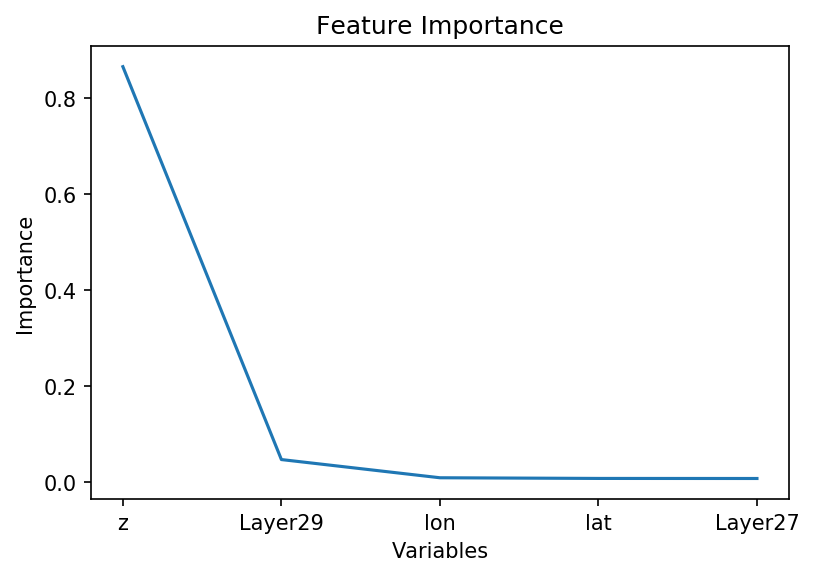

In [83]:
plt.plot(x[:5],y[:5])
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Variables')

In [128]:
df.sort_values(by='importance',ascending=False)

,feature,importance
4,z,0.865515
33,Layer29,0.047193
0,lon,0.009293
1,lat,0.007889
31,Layer27,0.007766
2,k_avg,0.005158
14,Layer10,0.005145
3,t_surf,0.003645
6,Layer2,0.003071
7,Layer3,0.002773


# Random Forest - Test only with important Variables

In [4]:
# only z
new_X = np.transpose(np.array([X[:,4],X[:,33]]))

In [5]:
temp_mae = []
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(new_X, Y, test_size=0.10, random_state=int(100*np.random.random()))
    model = RandomForestRegressor(max_depth=10, n_estimators=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    temp_mae.append(m.mean_absolute_error(y_test, y_pred))
np.mean(temp_mae)

3.3709900588819943

In [132]:
# z and layer 29
new_X = np.transpose(np.array([X[:,4],X[:,33]]))

In [133]:
temp_mae = []
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(new_X, Y, test_size=0.10, random_state=int(100*np.random.random()))
    model = RandomForestRegressor(max_depth=10, n_estimators=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    temp_mae.append(m.mean_absolute_error(y_test, y_pred))
np.mean(temp_mae)

3.319329930755539

In [134]:
# z layer29 lon lat
new_X = np.transpose(np.array([X[:,4],X[:,33],X[:,0],X[:,1]]))

In [135]:
temp_mae2 = []
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(new_X, Y, test_size=0.10, random_state=int(100*np.random.random()))
    model = RandomForestRegressor(max_depth=10, n_estimators=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    temp_mae2.append(m.mean_absolute_error(y_test, y_pred))
np.mean(temp_mae2)

3.18141137893048

In [136]:
model.feature_importances_

array([0.88104522, 0.0702721 , 0.02419749, 0.02448519])

# Ridge Regression Important Features

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import sklearn.metrics as m

X_train, X_test, y_train, y_test = train_test_split(scaled_X, Y, test_size=0.10, random_state=int(100*np.random.random()))
rid = Ridge(alpha=1)
rid.fit(X_train, y_train)
y_pred = rid.predict(X_test)
m.mean_absolute_error(y_test, y_pred)

3.433180358327517

In [15]:
rid.coef_

array([  0.19494074,  -1.75461664,  -0.14052501,  -2.57045019,
        11.60446909,  -3.66597093,   5.5684659 ,   7.89133406,
         1.20001662,  -3.1929711 ,   4.84677942,  -2.98441941,
        -8.37839117,  -0.57433468,   4.81178364,  -7.968981  ,
         0.93970195,  -2.40387102,  -2.73752624,  -3.34647192,
        -1.19034693,   1.79138257,  -2.31517445,   4.68867448,
        -2.86526285,   3.49293844,   2.28407278,   2.06269801,
        -9.81157076,   1.61247628,  -1.43274488,  -3.50473457,
        -0.42495873,   3.51277508,  -6.44519842,  -6.09516419,
        10.57610934,  13.94056232,   9.38288864, -27.37892907,
        -2.35705186,   5.23843965,   0.51497435,   2.80547627,
         2.90887895,   6.62467547,   4.54304774,   0.64969847,
         2.57408993,  -1.29213452,  -1.32801593,  -0.32063299,
         0.6323374 ,   0.12440158])

In [16]:
gen = []
for i in range(1,50):
    gen.append('Layer'+str(i))

df = pd.DataFrame({'feature':['lon','lat','k_avg','t_surf','z']+gen,
                   'importance':rid.coef_})

In [17]:
x=df.sort_values(by='importance',ascending=False).feature.values
y=df.sort_values(by='importance',ascending=False).importance.values

In [6]:
plt.plot(x[:54],y[:54])
plt.xticks(rotation='vertical',fontsize=5)
plt.title('Weight Decay')
plt.ylabel('Weight')
plt.xlabel('Variables')

NameError: name 'plt' is not defined

# XGBoost Feature Importance

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=(int(100*np.random.random())))
gbm = xgb.XGBRegressor(learning_rate=0.01,  
                       objective='reg:squarederror', 
                       n_estimators=2000, 
                       reg_alpha=10,
                       reg_lambda=0.1,
                       max_depth=10, 
                       gamma=10)
gbm.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=10,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=10, reg_lambda=0.1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [33]:
gen = []
for i in range(1,50):
    gen.append('Layer'+str(i))

df = pd.DataFrame({'feature':['lon','lat','k_avg','t_surf','z']+gen,
                   'importance':gbm.feature_importances_})

In [34]:
x=df.sort_values(by='importance',ascending=False).feature.values
y=df.sort_values(by='importance',ascending=False).importance.values

Text(0.5, 0, 'Variables')

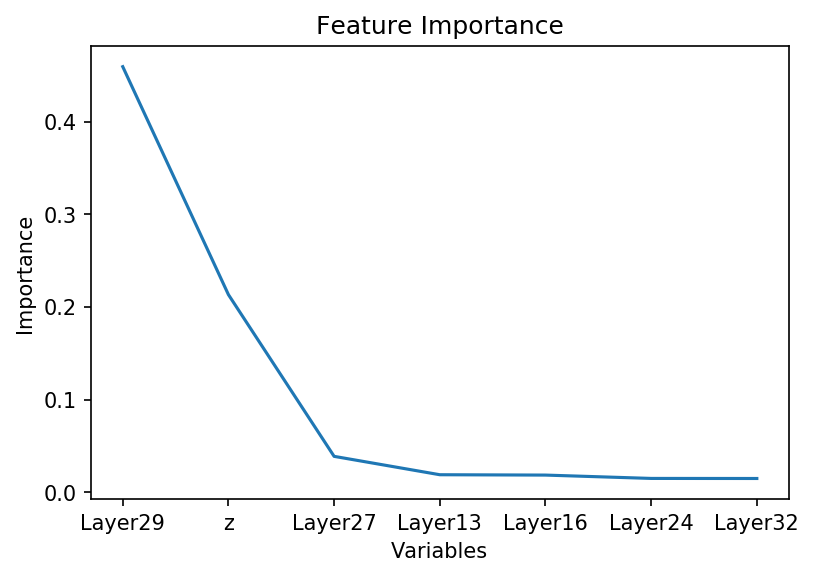

In [37]:
plt.plot(x[:7],y[:7])
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Variables')

# DNN Feature Importance

In [1]:
# From https://stackoverflow.com/questions/45361559/feature-importance-chart-in-neural-network-using-keras-in-python/52410345#52410345
import eli5
from eli5.sklearn import PermutationImportance

/home/aryashahdi/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/aryashahdi/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [13]:
gen = []
for i in range(1,50):
    gen.append('Layer'+str(i))

df = pd.DataFrame({'feature':['lon','lat','k_avg','t_surf','z']+gen})

In [9]:
# evaluate model

def baseline_model():
    # create model
    # Sequential model is for just building up each layer
    model = Sequential()
    # Kernel initializer sets up the distribution for the random parameters
    model.add(Dense(54, kernel_regularizer=regularizers.l2(200),
                    kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, kernel_regularizer=regularizers.l2(200),
                    kernel_initializer='normal', activation='relu'))    
    model.add(Dense(12, kernel_regularizer=regularizers.l2(200),
                    kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=10, verbose=0)
model.fit(X,Y)
perm = PermutationImportance(model, random_state=1).fit(X,Y)
temp = eli5.show_weights(perm, feature_names = df.feature.values)
temp

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [20]:
temp = eli5.show_weights(perm, feature_names = df.feature.values)
temp

Weight,Feature
265.4814 ± 4.8345,z
1.4855 ± 0.1192,Layer22
1.3612 ± 0.1093,Layer38
1.2738 ± 0.0553,Layer37
1.1645 ± 0.1164,Layer6
1.0986 ± 0.0533,Layer20
1.0080 ± 0.0892,Layer12
0.6375 ± 0.0539,Layer44
0.5196 ± 0.0288,Layer39
0.4588 ± 0.0410,Layer13
